In [1]:
import pvprog
from scipy.io import loadmat
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load time, electical load and p_pv
results=loadmat('../tests/pvprog_input.mat')
time1=results['time']
P_ld1=results['P_ld']
p_pv1=results['p_pv']
time=[]
P_ld=[]
p_pv=[]
for t in range(0,len(p_pv1),15):
    p_pv.append(p_pv1[t:t+14].mean())
    P_ld.append(P_ld1[t:t+14].mean())
    time.append(time1[t][0])
p_pv=np.array(p_pv)
P_ld=np.array(P_ld)
time=np.array(time)
P_stc=5 # Nennleistung des PV-Generators in kWp
C_bu=5 # nutzbare Speicherkapazität des Batteriespeichers in kWh 
P_inv=2.5# % Nennleistung des Batteriewechselrichters in kW
p_gfl=0.5#  spezifische Einspeisegrenze in kW/kWp (z.B. 50%-Einspeisebegrenzung des KfW-Programms)
dt=60*15# % Zeitschrittweite in s
eta_batt=0.95# % Wirkungsgrad des Lithium-Batteriespeichers (ohne AC/DC-Wandlung)
eta_inv=0.94# % Wirkungsgrad des Batteriewechselrichters
tf_past=3# % Rückblick-Zeitfenster der PV-Prognose in h 
tf_prog=15# % Prognosehorizont der PV- und Lastprognose in h
del (P_ld1, time1 , p_pv1 , results)

In [3]:
#create class
test=pvprog.BatProg(dt, P_stc, C_bu, P_inv, p_gfl, eta_batt, eta_inv, tf_past, tf_prog)

In [4]:
#load with forcast
P_b=np.zeros(len(time))
soc=np.zeros(len(time))
p_pvf=test.prog4pv(time,p_pv)
P_ldf,time_f = test.prog4ld(time,P_ld)
P_pv=p_pv*P_stc*1000
P_pvf=p_pvf*P_stc*1000
P_d=P_pv-P_ld
P_df=P_pvf-P_ldf
P_bf = 0
P_dfsel = 0
if C_bu>0:
    for t in range(1,len(time)):
        t_fsel=math.floor(t*dt/900)
        if (sum(P_pv[t:np.minimum(t+int(900/dt)+1,len(P_pv))])>0)&(time[t]==time_f[t_fsel]):
            P_bf,P_dfsel=test.batt_prog(t,P_df,soc)
        P_b[t]=test.err_ctrl(t,P_d,P_dfsel,P_bf)
        P_b[t],soc[t]=test.batt_sim(P_b[t],soc[t-1]) 
a,v,pf,eb=test.simu_erg(P_pv,P_ld,P_b)

In [5]:
eb

{'E_pv': 5020.245999980877,
 'E_ld': 5009.749000000001,
 'E_du': 1570.971483605976,
 'E_bc': 1309.4256361061286,
 'E_bd': 1099.1580674602064,
 'E_gf': 2081.867410512682,
 'E_gs': 2339.6194489338177,
 'E_ct': 57.98146975609094}

In [13]:
pfm= pd.DataFrame()
vars=['P_pv','P_ld','P_du','P_bc','P_bd','P_gf','P_gs','P_ct']
for i in range(0,8):
    pfm[vars[i]]=np.mean(np.reshape(pf[vars[i]],(96,365),order='F'),1)
pfm['time']=range(1,97)
pfm['P_cta']=pfm['P_ct']+pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_dua']=pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_bca']=pfm['P_bc']+pfm['P_gf']


pfm['P_gs']=-pfm['P_gs']-pfm['P_bd']-pfm['P_du']
pfm['P_bd']=-pfm['P_bd']-pfm['P_du']
pfm['P_du']=-pfm['P_du']
sns.reset_defaults()
s1 = sns.barplot(x='time',y = 'P_cta',data = pfm, color = 'black')
s2 = sns.barplot(x='time',y = 'P_dua', data = pfm, color = 'yellow')
s3 = sns.barplot(x='time',y = 'P_bca', data = pfm, color = 'lime')
s4 = sns.barplot(x='time',y = 'P_gf', data = pfm, color = 'darkgrey')
s5 = sns.barplot(x='time',y = 'P_gs', data = pfm, color = 'dimgrey')
s6 = sns.barplot(x='time',y = 'P_bd', data = pfm, color = 'darkgreen')
s7 = sns.barplot(x='time',y = 'P_du', data = pfm, color = 'yellow')

plt.title('Yearly average daily power flow \n forecast-based battery charging', fontsize=16)

#add axis titles
plt.xticks(range(-1,96,12),['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','00:00'])
plt.ylabel('Power in W')
plt.legend(labels=["regulation losses","direct usage","battery charge","grid feed-in","grid f","2","2"])
plt.show()

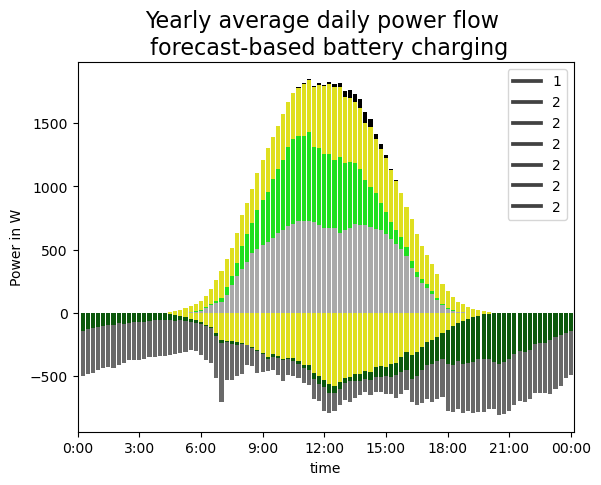